In [24]:
import pandas as pd
import numpy as np
import ast
import re

# --- 1) Нормализация тем ---
def _clean_token(x: str) -> str:
    x = str(x).strip().strip('"').strip("'")
    x = re.sub(r"\s+", " ", x)
    return x.lower()

def parse_timeline_themes(x):
    # timeline: "college expulsion, drug propaganda"
    if pd.isna(x):
        return []
    s = str(x).strip()
    if s == "" or s.lower() == "intro" or s.lower() == "sample":
        return []
    return [_clean_token(t) for t in s.split(",") if _clean_token(t)]

def parse_track_themes(x):
    """
    tracks: может быть
    - list
    - строка вида "['intro', ' start']"
    - строка с кавычками/запятыми
    - одиночное слово
    """
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return [_clean_token(t) for t in x if _clean_token(t)]

    s = str(x).strip()
    if s == "" or s.lower() in {"intro", "sample", "['']"}:
        return []

    # попробуем распарсить python-list
    if s.startswith("[") and s.endswith("]"):
        try:
            arr = ast.literal_eval(s)
            if isinstance(arr, list):
                return [_clean_token(t) for t in arr if _clean_token(t)]
        except Exception:
            pass

    # fallback: разбиваем по запятым
    return [_clean_token(t) for t in s.split(",") if _clean_token(t)]

# --- 2) Основная функция разметки таймлайна коэффициентами ---
def attach_coeffs_to_timeline(
    timeline_df: pd.DataFrame,
    tracks_df: pd.DataFrame,
    timeline_theme_col: str = "track_theme",
    tracks_theme_col: str = "theme",
    coeff_cols=("track_emo_score", "track_emo_score_v2"),
    extra_track_cols=("track_title", "album_title", "release_date_clean"),
):
    tl = timeline_df.copy()
    tr = tracks_df.copy()

    # темы -> списки
    tl["_themes"] = tl[timeline_theme_col].apply(parse_timeline_themes)
    tr["_themes"] = tr[tracks_theme_col].apply(parse_track_themes)

    # разворачиваем треки в "theme -> track row"
    tr_long = tr.explode("_themes").rename(columns={"_themes": "_theme"})
    tr_long["_theme"] = tr_long["_theme"].fillna("").map(_clean_token)
    tr_long = tr_long[tr_long["_theme"] != ""]

    # подготовим колонки для выдачи
    keep_cols = ["_theme", *[c for c in extra_track_cols if c in tr_long.columns], *[c for c in coeff_cols if c in tr_long.columns]]
    tr_long = tr_long[keep_cols].copy()

    # для каждой строки таймлайна собираем все совпавшие треки по её темам
    def collect_matches(theme_list):
        if not theme_list:
            return pd.DataFrame(columns=tr_long.columns)

        theme_set = set(theme_list)
        return tr_long[tr_long["_theme"].isin(theme_set)]

    # применяем
    matches = tl["_themes"].apply(collect_matches)

    # колонки-результаты (списки)
    tl["matched_tracks_n"] = matches.apply(len)

    # список треков (чтобы понимать, откуда коэффициенты)
    if "track_title" in tr_long.columns:
        tl["matched_track_titles"] = matches.apply(lambda df: df["track_title"].dropna().unique().tolist())

    # списки коэффициентов
    for col in coeff_cols:
        if col in tr_long.columns:
            tl[f"{col}_list"] = matches.apply(lambda df: df[col].dropna().tolist())
            tl[f"{col}_mean"] = matches.apply(lambda df: float(np.mean(df[col].dropna())) if len(df[col].dropna()) else np.nan)
            tl[f"{col}_median"] = matches.apply(lambda df: float(np.median(df[col].dropna())) if len(df[col].dropna()) else np.nan)

    # (опционально) список уникальных совпавших тем
    tl["matched_themes"] = tl["_themes"]

    return tl.drop(columns=["_themes"])

# --- 3) Использование ---
# timeline_df = ...   # твой таймлайн
# tracks_df = ...     # твой датасет треков
timeline_with_coeffs = attach_coeffs_to_timeline(
    timeline_df=timeline_df,
    tracks_df=tracks_df,
    timeline_theme_col="track_theme",
    tracks_theme_col="theme",
    coeff_cols=("track_emo_score", "track_emo_score_v2"),
)

# посмотреть
timeline_with_coeffs.head(10)

# сохранить
timeline_with_coeffs

,year,month,era,key_event,category,mental_state,intensity,source,track_theme,_themes_list,matched_tracks_n,matched_track_titles,track_emo_score_list,track_emo_score_mean,track_emo_score_median,track_emo_score_v2_list,track_emo_score_v2_mean,track_emo_score_v2_median,matched_themes
0,2004,1,College Dropout Era,Finishing The College Dropout,music,creative_peak,4,Pitchfork,"college expulsion, drug propaganda","[college expulsion, drug propaganda]",2,[Graduation Day],"[11.653805172413795, 11.653805172413795]",11.653805,11.653805,"[67.4301299838362, 67.4301299838362]",67.430130,67.430130,"[college expulsion, drug propaganda]"
1,2004,2,College Dropout Era,Release of The College Dropout,music,joy,5,Billboard,"college expulsion, drug propaganda","[college expulsion, drug propaganda]",2,[Graduation Day],"[11.653805172413795, 11.653805172413795]",11.653805,11.653805,"[67.4301299838362, 67.4301299838362]",67.430130,67.430130,"[college expulsion, drug propaganda]"
2,2004,3,College Dropout Era,Through the Wire success,music,joy,4,RollingStone,"success, hustle, self-worth","[success, hustle, self-worth]",16,"[Workout Plan, Drive Slow, We Major, Celebrati...","[1.1161899641577038, 1.1050666666666664, -0.22...",8.747957,0.564149,"[25.153598734318997, 10.714666666666671, 33.86...",29.452221,30.625574,"[success, hustle, self-worth]"
3,2004,4,College Dropout Era,First major tour,music,creative_peak,3,Variety,"intro, start","[intro, start]",3,"[Intro, Wake Up Mr. West]","[147.84, -1.5274999999999987, -1.5274999999999...",48.261667,-1.527500,"[60.68000000000001, 36.471093749999994, 36.471...",44.540729,36.471094,"[intro, start]"
4,2004,5,College Dropout Era,Beginning of GOOD Music,music,creative_peak,4,Guardian,"intro, start","[intro, start]",3,"[Intro, Wake Up Mr. West]","[147.84, -1.5274999999999987, -1.5274999999999...",48.261667,-1.527500,"[60.68000000000001, 36.471093749999994, 36.471...",44.540729,36.471094,"[intro, start]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,2025,2,New Era,XTwitter account terminated,public,public_controversy,4,Variety,"college expulsion, drug propaganda","[college expulsion, drug propaganda]",2,[Graduation Day],"[11.653805172413795, 11.653805172413795]",11.653805,11.653805,"[67.4301299838362, 67.4301299838362]",67.430130,67.430130,"[college expulsion, drug propaganda]"
265,2025,3,New Era,Minimal public activity,personal,neutral,1,Guardian,"toxicity, idleness, society, alcohol, oblivion...","[toxicity, idleness, society, alcohol, oblivio...",9,"[Drunk and Hot Girls, Hold My Liquor, Blood on...","[14.858729044834304, 30.210032327586216, 0.183...",7.404137,3.564244,"[46.43912280701755, 60.49266029094827, 37.4453...",63.731714,71.534714,"[toxicity, idleness, society, alcohol, oblivio..."
266,2025,4,New Era,Studio rumors,music,neutral,2,Pitckfork,"chaos, fame, consequences","[chaos, fame, consequences]",22,"[Diamonds from Sierra Leone (Remix), Flashing ...","[-0.7207693181818179, -2.3659259259259273, 10....",13.941554,8.474583,"[31.150144797585217, 2.254145833333333, 45.014...",42.447712,48.058318,"[chaos, fame, consequences]"
267,2025,5,New Era,Private life,personal,neutral,1,--,"vulnerability, confession, identity","[vulnerability, confession, identity]",15,[Pinocchio Story (Freestyle Live From Singapor...,"[56.72868276972627, 33.28546950354608, -1.7300...",20.804307,8.606448,"[56.20711050724637, 71.92355200945624, 40.6279...",46.183590,45.118073,"[vulnerability, confession, identity]"


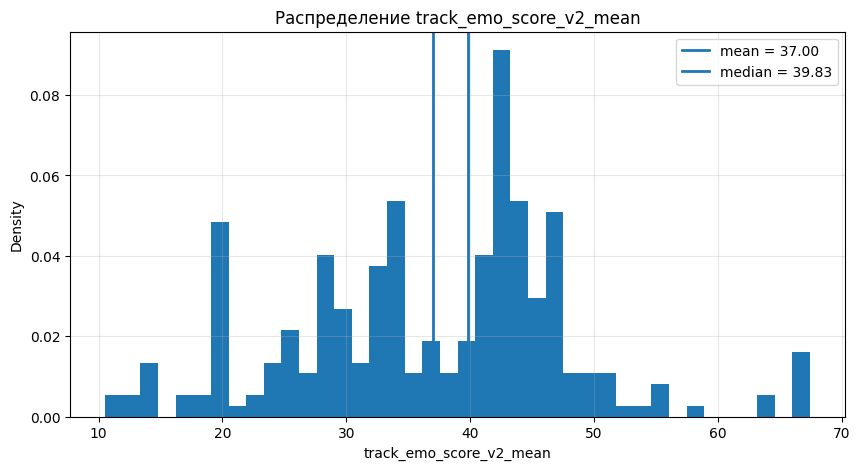

In [25]:
import matplotlib.pyplot as plt

col = "track_emo_score_v2_mean"
x = timeline_with_coeffs[col].dropna()

plt.figure(figsize=(10, 5))
plt.hist(x, bins=40, density=True)

plt.axvline(x.mean(), linewidth=2, label=f"mean = {x.mean():.2f}")
plt.axvline(x.median(), linewidth=2, label=f"median = {x.median():.2f}")

plt.title(f"Распределение {col}")
plt.xlabel(col)
plt.ylabel("Density")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


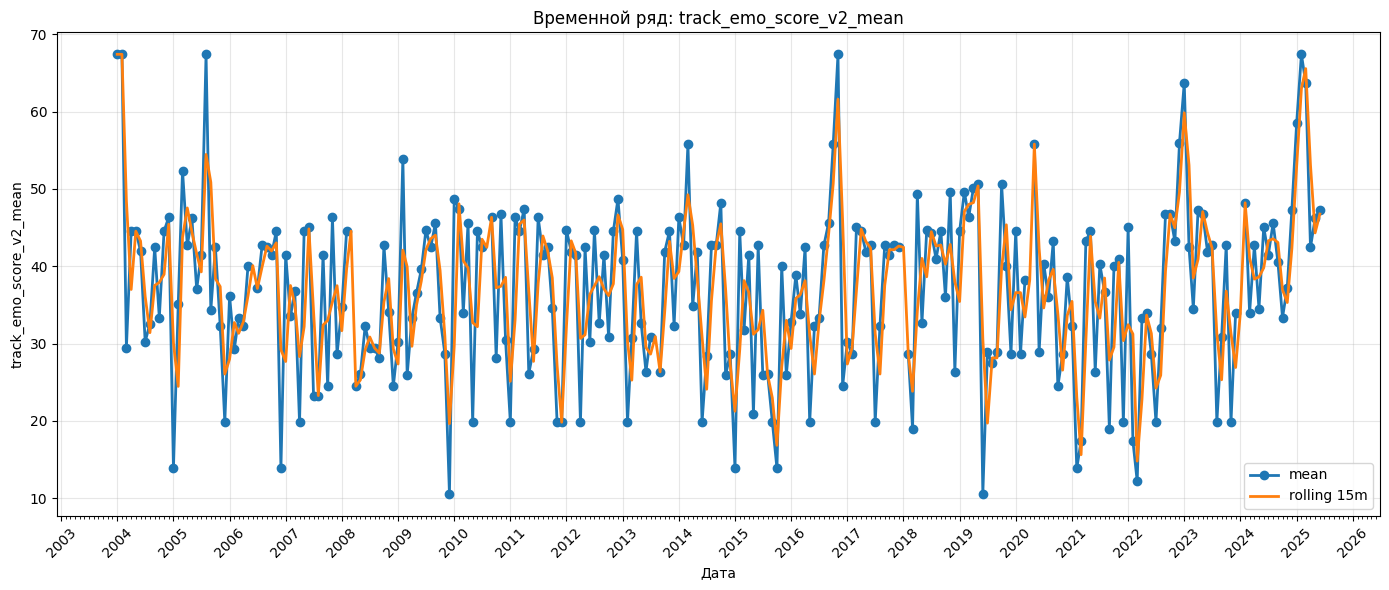

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = timeline_with_coeffs.copy()

# 1) Собираем дату из year + month (ставим 1-е число месяца)
df["date"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))

# 2) На всякий случай агрегируем по месяцам (если есть дубли строк на один month)
ts = (
    df.groupby("date", as_index=False)["track_emo_score_v2_mean"]
      .mean()
      .sort_values("date")
)

# (опционально) сглаживание
ts["rolling_3m"] = ts["track_emo_score_v2_mean"].rolling(2, min_periods=1).mean()

# 3) График
plt.figure(figsize=(14, 6))
plt.plot(ts["date"], ts["track_emo_score_v2_mean"], marker="o", linewidth=2, label="mean")
plt.plot(ts["date"], ts["rolling_3m"], marker=None, linewidth=2, label="rolling 15m")

plt.title("Временной ряд: track_emo_score_v2_mean")
plt.xlabel("Дата")
plt.ylabel("track_emo_score_v2_mean")
plt.grid(True, alpha=0.3)
plt.legend()

# Красивые даты на оси X
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
import pandas as pd

df = timeline_with_coeffs.copy()

# дата (1-е число месяца)
df["date"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))

# агрегация по месяцу (если есть дубли)
ts = (
    df.groupby("date", as_index=False)["track_emo_score_v2_mean"]
      .mean()
      .sort_values("date")
)

# скользящее среднее 15 месяцев
ts["rolling_15m"] = ts["track_emo_score_v2_mean"].rolling(15, min_periods=1).mean()

# ✅ датасет только со значениями скользящего окна
rolling_df = ts[["date", "rolling_15m"]].copy()

# (опционально) добавить year/month обратно
rolling_df["year"] = rolling_df["date"].dt.year
rolling_df["month"] = rolling_df["date"].dt.month
rolling_df = rolling_df[["year", "month", "date", "rolling_15m"]]

rolling_df.head()

,year,month,date,rolling_15m
0,2004,1,2004-01-01,67.430130
1,2004,2,2004-02-01,67.430130
2,2004,3,2004-03-01,54.770827
3,2004,4,2004-04-01,52.213302
4,2004,5,2004-05-01,50.678788


In [28]:
rolling_df.to_csv("timeline_rolling_15m.csv", index=False)

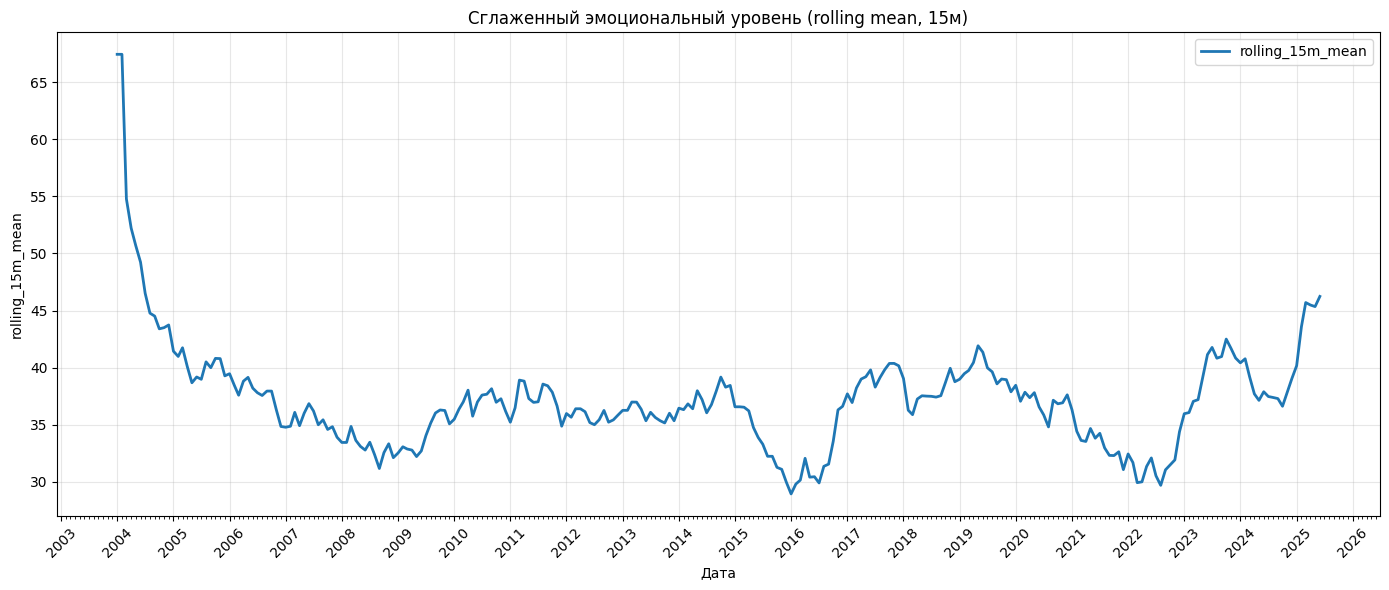

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = timeline_with_coeffs.copy()

# 1) дата из year + month
df["date"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))

# 2) агрегируем по месяцам
ts = (
    df.groupby("date", as_index=False)["track_emo_score_v2_mean"]
      .mean()
      .sort_values("date")
)

# 3) rolling mean + rolling std (окно 15 месяцев)
window = 15
ts["rolling_15m_mean"] = ts["track_emo_score_v2_mean"].rolling(window, min_periods=1).mean()
ts["rolling_15m_std"]  = ts["track_emo_score_v2_mean"].rolling(window, min_periods=2).std()

state_df = ts[["date", "rolling_15m_mean", "rolling_15m_std"]].copy()

# ===== График 1: сглаженная средняя =====
plt.figure(figsize=(14, 6))
plt.plot(state_df["date"], state_df["rolling_15m_mean"], linewidth=2, label="rolling_15m_mean")
plt.title("Сглаженный эмоциональный уровень (rolling mean, 15м)")
plt.xlabel("Дата")
plt.ylabel("rolling_15m_mean")
plt.grid(True, alpha=0.3)
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Saved -> timeline_rolling_2m.csv


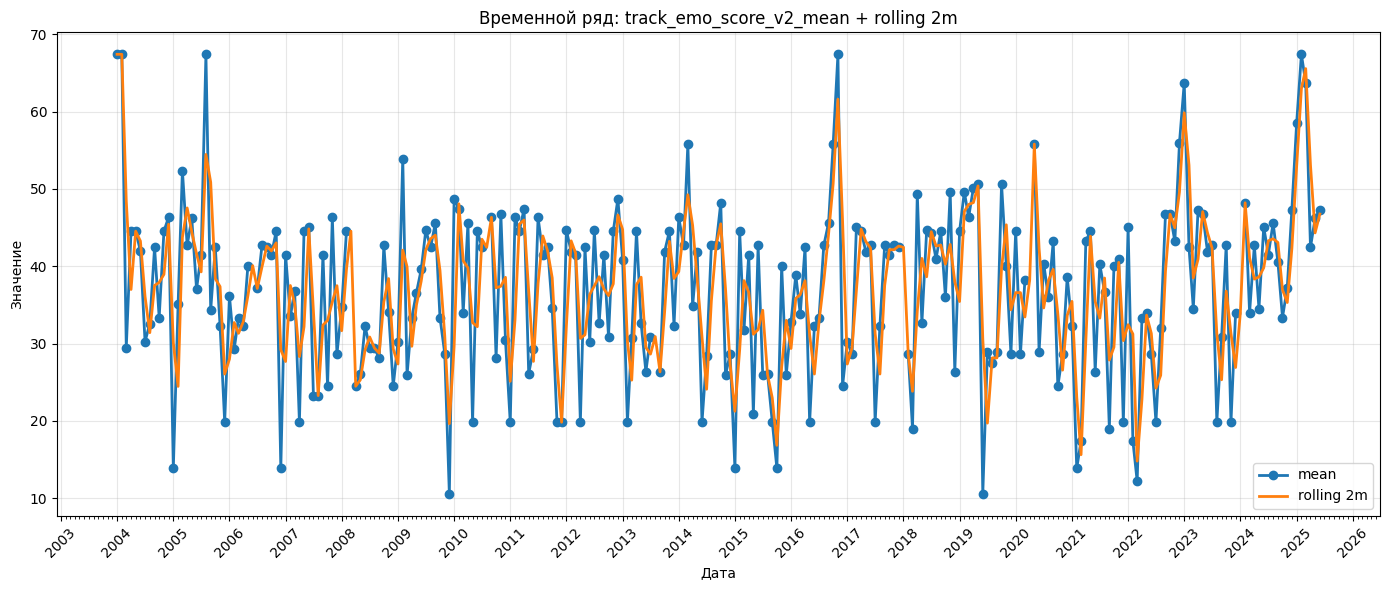

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = timeline_with_coeffs.copy()

# 1) дата = 1-е число месяца
df["date"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))

# 2) агрегируем по месяцам
ts = (
    df.groupby("date", as_index=False)["track_emo_score_v2_mean"]
      .mean()
      .sort_values("date")
)

# 3) скользящее окно (2 месяца)
ts["rolling_2m"] = ts["track_emo_score_v2_mean"].rolling(2, min_periods=1).mean()

# 4) сохраняем датасет ТОЛЬКО с окном (и датой)
out = ts[["date", "rolling_2m"]].copy()
out["year"] = out["date"].dt.year
out["month"] = out["date"].dt.month

out = out[["year", "month", "date", "rolling_2m"]]
out.to_csv("timeline_rolling_2m.csv", index=False)
print("Saved -> timeline_rolling_2m.csv")

# (опционально) график
plt.figure(figsize=(14, 6))
plt.plot(ts["date"], ts["track_emo_score_v2_mean"], marker="o", linewidth=2, label="mean")
plt.plot(ts["date"], ts["rolling_2m"], linewidth=2, label="rolling 2m")

plt.title("Временной ряд: track_emo_score_v2_mean + rolling 2m")
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.grid(True, alpha=0.3)
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/p_/rq2plg214fx0yv72l4tsnccr0000gn/T/ipykernel_19622/3160159093.py:119: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg = ax.legend(frameon=True, loc="upper right")


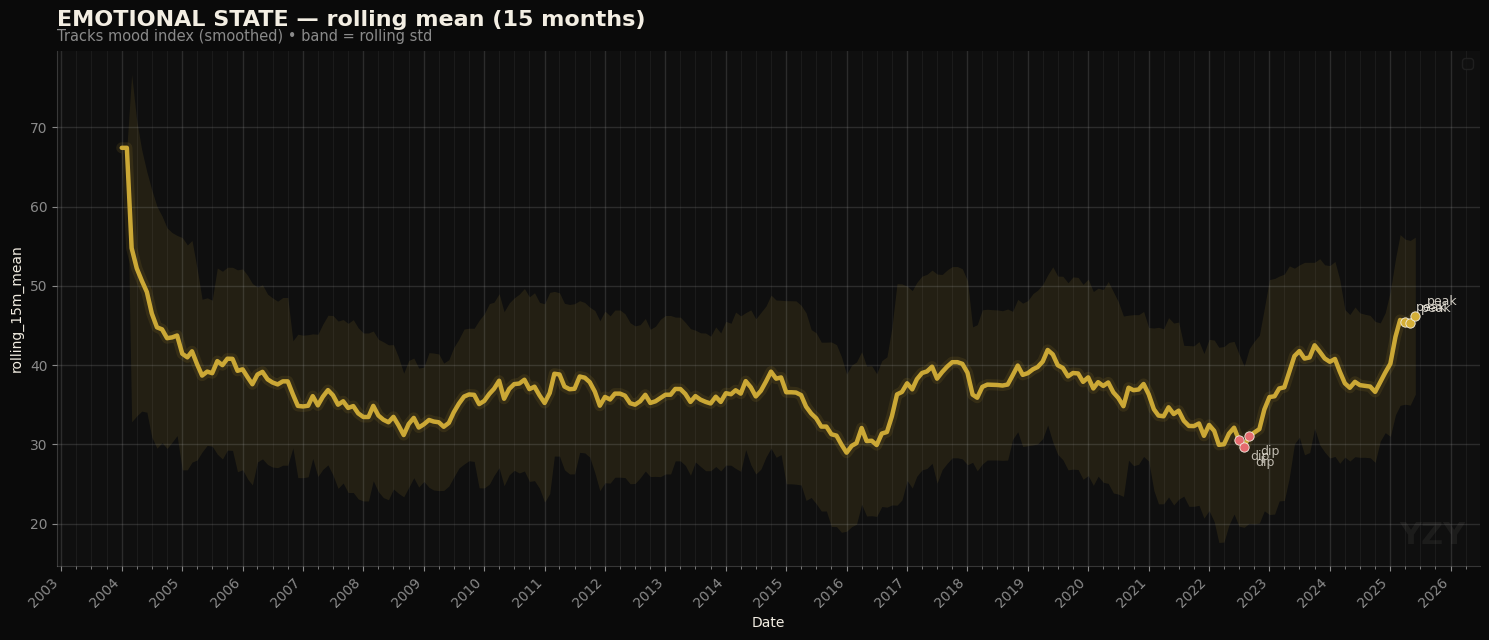

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# =========================
# 1) ДАННЫЕ + ROLLING
# =========================
df = timeline_with_coeffs.copy()

df["date"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))

ts = (
    df.groupby("date", as_index=False)["track_emo_score_v2_mean"]
      .mean()
      .sort_values("date")
)

window = 15
ts["rolling_15m_mean"] = ts["track_emo_score_v2_mean"].rolling(window, min_periods=1).mean()
ts["rolling_15m_std"]  = ts["track_emo_score_v2_mean"].rolling(window, min_periods=2).std()

state_df = ts[["date", "rolling_15m_mean", "rolling_15m_std"]].copy()
state_df["upper"] = state_df["rolling_15m_mean"] + state_df["rolling_15m_std"].fillna(0)
state_df["lower"] = state_df["rolling_15m_mean"] - state_df["rolling_15m_std"].fillna(0)

# точки для аккуратных меток (топ/боттом по квантилям)
q_hi = state_df["rolling_15m_mean"].quantile(0.95)
q_lo = state_df["rolling_15m_mean"].quantile(0.05)
hi_pts = state_df[state_df["rolling_15m_mean"] >= q_hi].tail(3)
lo_pts = state_df[state_df["rolling_15m_mean"] <= q_lo].tail(3)

# =========================
# 2) “KANYE / YEEZY” STYLE
# =========================
BG      = "#0A0A0A"   # почти чёрный
PANEL   = "#0F0F0F"   # чуть светлее для области графика
TEXT    = "#F3EEE3"   # тёплый белый
MUTED   = "#8A8A8A"   # приглушённый серый
ACCENT  = "#D4AF37"   # “gold”
ACCENT2 = "#E56B6F"   # второй акцент (очень умеренно)

plt.rcParams.update({
    "figure.facecolor": BG,
    "axes.facecolor": PANEL,
    "axes.edgecolor": MUTED,
    "axes.labelcolor": TEXT,
    "xtick.color": MUTED,
    "ytick.color": MUTED,
    "text.color": TEXT,
    "font.family": "DejaVu Sans",
})

fig, ax = plt.subplots(figsize=(15, 6.5))

x = state_df["date"]
y = state_df["rolling_15m_mean"]

# “glow” под основной линией (очень модный минимализм)
ax.plot(x, y, linewidth=8, color=ACCENT, alpha=0.10, solid_capstyle="round", zorder=2)
ax.plot(x, y, linewidth=3.2, color=ACCENT, alpha=0.95, solid_capstyle="round", zorder=3)

# диапазон неопределенности (rolling std)
ax.fill_between(
    x,
    state_df["lower"].values,
    state_df["upper"].values,
    color=ACCENT,
    alpha=0.10,
    linewidth=0,
    zorder=1
)

# тонкая “нить” для ощущения ритма
ax.plot(x, y, linewidth=1.2, color=TEXT, alpha=0.12, zorder=2)

# точки-акценты на экстремумах
ax.scatter(hi_pts["date"], hi_pts["rolling_15m_mean"], s=45, color=ACCENT, edgecolor=TEXT, linewidth=0.6, zorder=4)
ax.scatter(lo_pts["date"], lo_pts["rolling_15m_mean"], s=45, color=ACCENT2, edgecolor=TEXT, linewidth=0.6, zorder=4)

for _, r in hi_pts.iterrows():
    ax.annotate("peak", (r["date"], r["rolling_15m_mean"]),
                textcoords="offset points", xytext=(8, 8),
                fontsize=9, color=TEXT, alpha=0.85)

for _, r in lo_pts.iterrows():
    ax.annotate("dip", (r["date"], r["rolling_15m_mean"]),
                textcoords="offset points", xytext=(8, -14),
                fontsize=9, color=TEXT, alpha=0.75)

# заголовок + подзаголовок
ax.set_title("EMOTIONAL STATE — rolling mean (15 months)", fontsize=16, pad=18, loc="left", fontweight="bold")
ax.text(
    0.0, 1.02,
    "Tracks mood index (smoothed) • band = rolling std",
    transform=ax.transAxes, fontsize=10.5, color=MUTED
)

ax.set_xlabel("Date")
ax.set_ylabel("rolling_15m_mean")

# сетка: минимальная, “дорогая”
ax.grid(True, which="major", alpha=0.18, linewidth=1.0)
ax.grid(True, which="minor", alpha=0.08, linewidth=0.8)

# ось времени
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# убрать лишние рамки
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_alpha(0.35)
ax.spines["bottom"].set_alpha(0.35)

# легенда: аккуратная
leg = ax.legend(frameon=True, loc="upper right")
leg.get_frame().set_facecolor("#111111")
leg.get_frame().set_edgecolor("#222222")
leg.get_frame().set_alpha(0.85)

# водяной знак (очень subtle)
ax.text(
    0.99, 0.03, "YZY",
    transform=ax.transAxes, ha="right", va="bottom",
    fontsize=22, color=TEXT, alpha=0.06, fontweight="bold"
)

plt.tight_layout()

# если хочешь — сохраняй в хай-рес
# plt.savefig("kanye_style_emotional_state.png", dpi=220, facecolor=BG, bbox_inches="tight")

plt.show()

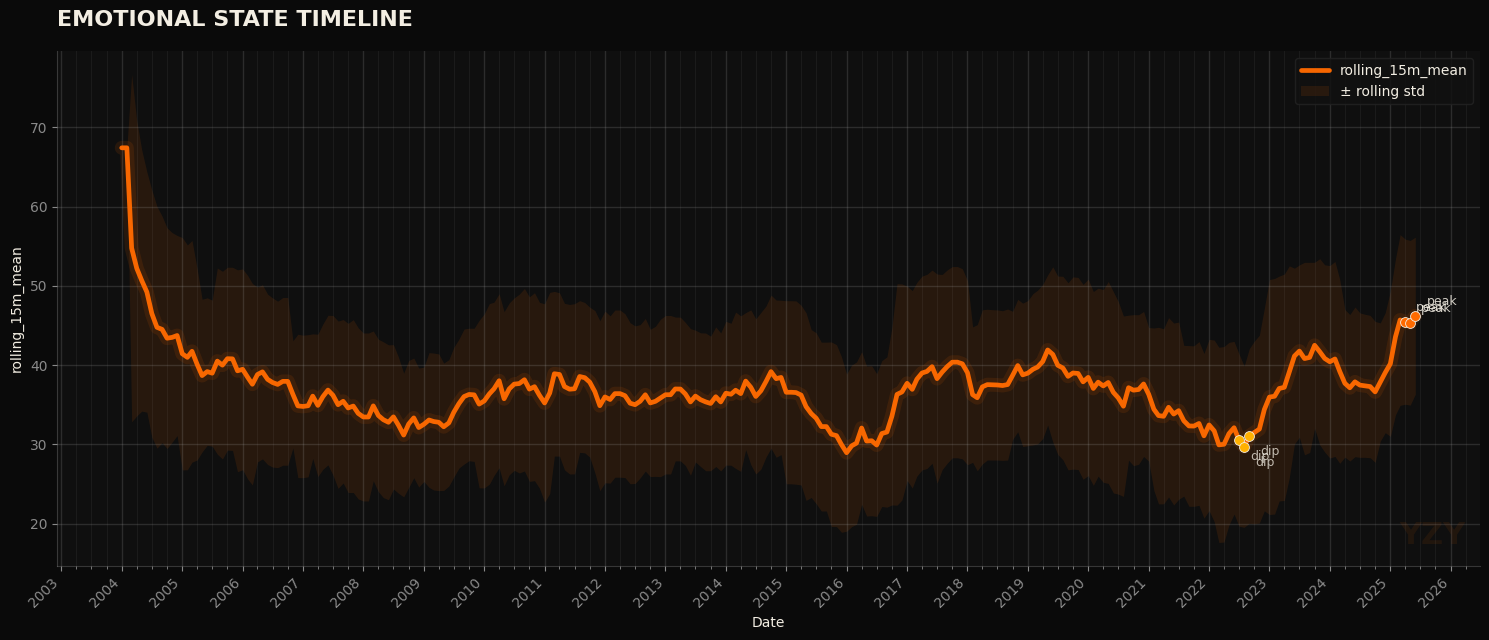

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# =========================
# 1) ДАННЫЕ + ROLLING
# =========================
df = timeline_with_coeffs.copy()

df["date"] = pd.to_datetime(dict(year=df["year"], month=df["month"], day=1))

ts = (
    df.groupby("date", as_index=False)["track_emo_score_v2_mean"]
      .mean()
      .sort_values("date")
)

window = 15
ts["rolling_15m_mean"] = ts["track_emo_score_v2_mean"].rolling(window, min_periods=1).mean()
ts["rolling_15m_std"]  = ts["track_emo_score_v2_mean"].rolling(window, min_periods=2).std()

state_df = ts[["date", "rolling_15m_mean", "rolling_15m_std"]].copy()
state_df["upper"] = state_df["rolling_15m_mean"] + state_df["rolling_15m_std"].fillna(0)
state_df["lower"] = state_df["rolling_15m_mean"] - state_df["rolling_15m_std"].fillna(0)

# точки для аккуратных меток (топ/боттом по квантилям)
q_hi = state_df["rolling_15m_mean"].quantile(0.95)
q_lo = state_df["rolling_15m_mean"].quantile(0.05)
hi_pts = state_df[state_df["rolling_15m_mean"] >= q_hi].tail(3)
lo_pts = state_df[state_df["rolling_15m_mean"] <= q_lo].tail(3)

# =========================
# 2) “KANYE / YEEZY” STYLE (ORANGE ACCENT)
# =========================
BG      = "#0A0A0A"
PANEL   = "#0F0F0F"
TEXT    = "#F3EEE3"
MUTED   = "#8A8A8A"
ACCENT  = "#FF6A00"   # ORANGE accent (main)
ACCENT2 = "#FFB000"   # warm amber for secondary points (optional)

plt.rcParams.update({
    "figure.facecolor": BG,
    "axes.facecolor": PANEL,
    "axes.edgecolor": MUTED,
    "axes.labelcolor": TEXT,
    "xtick.color": MUTED,
    "ytick.color": MUTED,
    "text.color": TEXT,
    "font.family": "DejaVu Sans",
})

fig, ax = plt.subplots(figsize=(15, 6.5))

x = state_df["date"]
y = state_df["rolling_15m_mean"]

# “glow” под основной линией
ax.plot(x, y, linewidth=10, color=ACCENT, alpha=0.10, solid_capstyle="round", zorder=2)
ax.plot(x, y, linewidth=3.4, color=ACCENT, alpha=0.97, solid_capstyle="round",
        label="rolling_15m_mean", zorder=3)

# диапазон неопределенности (rolling std)
ax.fill_between(
    x,
    state_df["lower"].values,
    state_df["upper"].values,
    color=ACCENT,
    alpha=0.10,
    linewidth=0,
    label="± rolling std",
    zorder=1
)

# тонкая “нить” (очень subtle)
ax.plot(x, y, linewidth=1.2, color=TEXT, alpha=0.10, zorder=2)

# точки-акценты
ax.scatter(hi_pts["date"], hi_pts["rolling_15m_mean"],
           s=50, color=ACCENT, edgecolor=TEXT, linewidth=0.6, zorder=4)
ax.scatter(lo_pts["date"], lo_pts["rolling_15m_mean"],
           s=50, color=ACCENT2, edgecolor=TEXT, linewidth=0.6, zorder=4)

for _, r in hi_pts.iterrows():
    ax.annotate("peak", (r["date"], r["rolling_15m_mean"]),
                textcoords="offset points", xytext=(8, 8),
                fontsize=9, color=TEXT, alpha=0.85)

for _, r in lo_pts.iterrows():
    ax.annotate("dip", (r["date"], r["rolling_15m_mean"]),
                textcoords="offset points", xytext=(8, -14),
                fontsize=9, color=TEXT, alpha=0.75)

# заголовок + подзаголовок
ax.set_title("EMOTIONAL STATE TIMELINE", fontsize=16, pad=18, loc="left", fontweight="bold")


ax.set_xlabel("Date")
ax.set_ylabel("rolling_15m_mean")

# сетка
ax.grid(True, which="major", alpha=0.18, linewidth=1.0)
ax.grid(True, which="minor", alpha=0.08, linewidth=0.8)

# ось времени
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# рамки
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_alpha(0.35)
ax.spines["bottom"].set_alpha(0.35)

# легенда
leg = ax.legend(frameon=True, loc="upper right")
leg.get_frame().set_facecolor("#111111")
leg.get_frame().set_edgecolor("#222222")
leg.get_frame().set_alpha(0.85)

# watermark
ax.text(0.99, 0.03, "YZY",
        transform=ax.transAxes, ha="right", va="bottom",
        fontsize=22, color=ACCENT, alpha=0.08, fontweight="bold")

plt.tight_layout()
# plt.savefig("kanye_style_emotional_state_orange.png", dpi=220, facecolor=BG, bbox_inches="tight")
plt.show()